# 03) Improve labels

A key problem with the headlines data is that keyword matching during the data collection process likely resulted in missed risk headlines that are now wrongly assumed to be non-risk. To tackle this problem, a regression model for each language (Spanish and Portuguese) is trained on half of the data at a time to generate predictions for the other half's headlines. A slice of low probability headlines are then used for the non-risk category.

## Read-in data

Seperate dataframes are read-in for each language and dataset type. 

In [1]:
import pandas as pd
import numpy as np

# reads in the spanish train headlines
spanish_train_df = pd.read_csv('../Data/spanish_train_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_train_df)/1000, 1)) + 'K Spanish train headlines')

# reads in the spanish put aside headlines
spanish_put_aside_df = pd.read_csv('../Data/spanish_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_put_aside_df)/1000, 1)) + 'K Spanish put aside headlines')

# reads in the portuguese train headlines
portuguese_train_df = pd.read_csv('../Data/portuguese_train_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_train_df)/1000, 1)) + 'K Portuguese train headlines')

# reads in the portuguese put aside headlines
portuguese_put_aside_df = pd.read_csv('../Data/portuguese_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_put_aside_df)/1000, 1)) + 'K Portuguese put aside headlines')

74.9K Spanish train headlines
0.6K Spanish put aside headlines
15.0K Portuguese train headlines
0.6K Portuguese put aside headlines


## Filter labels

### Half dataframes

Each dataframe is randomly split into two sets so a model can be trained on each set and used to predict headlines for the other.

In [2]:
# randomly split a dataframe into 2 equal size groups 
def half_dataframes(df):
    population = list(range(len(df)))
    half_headlines = int(np.floor(len(population) / 2))
    random_samples = random.sample(population, half_headlines)
    return df.loc[random_samples,:].reset_index(drop=True), df.loc[~df.index.isin(random_samples), :].reset_index(drop=True)

### Fit model

A model is fit using TF-IDF vectors and logistic regression. A regression model is used to obtain probabilities so that the classification threshold can be easily varied. 

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# vectorizes data and fits a model 
def fit_model(df):
    X, y = df.headline, [int(pd.notna(x)) for x in df.risk_type]
    vectorizer = TfidfVectorizer()
    train_tfidf = vectorizer.fit_transform(X)
    model = LogisticRegression()
    model.fit(train_tfidf, y)
    return vectorizer, model

### Add predictions

Predictions from one half of each dataset are added to the other half and vice versa.

In [4]:
import random

# returns predictions as binary decisions and probabilities
def predict_headlines(df, vectorizer, model):
    tfidf_vectors = vectorizer.transform(df.headline)
    y_preds = model.predict(tfidf_vectors)
    y_pred_prob = [np.mean(model.predict_proba(x)[:, 1]) for x in tfidf_vectors]
    return y_preds, y_pred_prob 

# adds the predictions for each half of the data to their respective dfs
def add_predictions_to_df(primary_df, secondary_df):
    vectorizer, model = fit_model(secondary_df)
    y_preds, y_pred_prob = predict_headlines(primary_df, vectorizer, model)
    primary_df['y_pred'], primary_df['y_pred_prob'] = y_preds, y_pred_prob
    primary_df.sort_values('y_pred_prob', ascending=False, inplace=True)
    return primary_df

# returns a headlines dataframe along with their predictions for veiwing
# this is useful so we can set appropriate upper and lower limits for the 
# slice of low probability non-risk headlines we will select later on
def return_headline_preds(df, language):
    df_1, df_2 = half_dataframes(df) 
    df_1, df_2 = add_predictions_to_df(df_1, df_2), add_predictions_to_df(df_2, df_1)
    return df_1, df_2

spanish_df_1, spanish_df_2 = return_headline_preds(spanish_train_df, 'Spanish')
portuguese_df_1, portuguese_df_2 = return_headline_preds(portuguese_train_df, 'Portuguese')

### Find false negatives threshold

The threshold at which false negatives are no longer common is located.

In [5]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
def view_nonrisk_highest_rows(df, start, end):
    temp_df = df.loc[pd.isna(df.risk_type)].sort_values('y_pred_prob')
    print()
    print('Total non-risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent

spanish_false_negative_percent = view_nonrisk_highest_rows(spanish_df_1, 7990, 8000)
portuguese_false_negative_percent = view_nonrisk_highest_rows(portuguese_df_1, 1990, 2000)


Total non-risk headlines: 32319

1197:   apuestas futuro frustraciones
9999:   aerolíneas colombia asustadas fallo microsoft link verificar vuelos
34966:   11 julio 2024 719 pm11 julio 2024 907 pm
29176:   pasará usuarios afectados cancelación vuelos escasez combustible
6687:   peces muriendo recomienda acercarse terreno fangoso
25568:   justicia dio vía libre aumentos tarifa subte premetro cuánto irá boleto
24797:   mayo capo invisible
32469:   nación cnsc abrió 59 vacantes empleo nivel nacional plazo 15 agosto abrieron inscripciones ofertas laborales disponibles niveles profesional técnico asistencial trabajar
23888:   4 ordenaron bloquear 50 dominios fútbol libre fundador megadeportes detenido
1267:   confirman aumento precio boleto colectivo plata cuándo tarifas

Total non-risk headlines: 5803

330:   prefeitura cotia sp interdita clínica reabilitação paciente morto após agredido funcionários
4785:   governador clécio convoca 70 aprovados concurso receita estadual fase documental


### Drop false negatives

All non-risk headlines above the threshold above are dropped, eliminating many false negatives and tackling the class imbalance problem (see notebook 1).

In [6]:
# drops a number of non-risk headlines based on their prediction scores
def drop_non_risk_headlines(df, percent):   
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    risk_df = df.loc[~pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(non_risk_df) * percent))
    low_score_non_risk = non_risk_df.iloc[(len(non_risk_df)-upper_limit):(len(non_risk_df)-lower_limit),:]
    return pd.concat([risk_df, low_score_non_risk])

# creates a filtered dataframe combining both halfs of the data 
# after dropping headlines with high predictions
def create_filtered_df(df_1, df_2, percent):
    df_1, df_2 =  drop_non_risk_headlines(df_1, percent), drop_non_risk_headlines(df_2, percent)
    return pd.concat([df_1, df_2])

false_negatives_filtered_spanish_df = create_filtered_df(spanish_df_1, spanish_df_2, spanish_false_negative_percent)
false_negatives_filtered_portuguese_df = create_filtered_df(portuguese_df_1, portuguese_df_2, portuguese_false_negative_percent)

### Find false positives threshold

The threshold for false positives is found by exploring the data.

In [7]:
# this function shows the risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false positives in the data...
def view_risk_lowest_rows(df, start, end):
    temp_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob').reset_index(drop=True)
    print()
    print('Risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent
    
spanish_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_spanish_df, 60, 70)
portuguese_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_portuguese_df, 40, 50)


Risk headlines: 10375

60:   day vásquez aceptó cargos delito violación datos personales sigue caso
61:   confirman condena abogado musa besaile cohecho caso ‘cartel toga’
62:   cesan elementos viales denuncia extorsiónel ayuntamiento gómez palacio través dirección tránsito vialidad informó ciudadanía cese dos elementos vialidad reportados un…
63:   auge ‘trading línea cómo participar mercado
64:   colombia gana multimillonario litigio unidos megapredio mafia
65:   boyacense jaime raúl salamanca cercano carlos amaya disputará presidencia cámara verdes
66:   generado mucha expectativa anuncio través líneas hizo administración municipal relacionado contratación consultoría explorar todas opciones permitan volver parque leyenda vallenata centro actividad cultural permanente 365 días año
67:   evite multas pico placa cali lunes 26 agosto 2024
68:   renunciado 549 filas estatal
69:   despliegan búsqueda señalado responsable ‘carrobomba’

Risk headlines: 3294

40:   ceron diz orçamento 2025

### Drop false positives

Many false posiitves are dropped from the data based on their percentage ranking when ordered by their y preds.

In [8]:
# drops a number of risk headlines based on their prediction scores
def drop_risk_headlines(df, percent):   
    risk_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob')
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(risk_df) * percent))
    high_score_risk = risk_df.iloc[upper_limit:len(risk_df),:]
    combined_df = pd.concat([high_score_risk, non_risk_df])
    return combined_df.reset_index(drop=True)

false_positives_filtered_spanish_df = drop_risk_headlines(false_negatives_filtered_spanish_df, spanish_false_positive_percent)
false_positives_filtered_portuguese_df = drop_risk_headlines(false_negatives_filtered_portuguese_df, portuguese_false_positive_percent)

## Evaluate performance

### Train test split

Creates a train test split for a given dataframe.

In [9]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, test_size=0.25):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=test_size, stratify=y)

### Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# creates a confusion matrix heatmap
def heatmap(conf_matrix_df, colors):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_df, annot=True, cmap=colors, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# evaluates the model's performance and prints the results
def evaluate_model(model, X_test_tfidf, y_test, colors):
    y_pred = model.predict(X_test_tfidf)
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1] 
    classification_report_ = classification_report(y_test, y_pred)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print()
    print("Classification Report:\n", classification_report_)
    print()
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Risk', 'Actual Risk'], columns=['Pred Non-Risk', 'Pred Risk'])
    heatmap(conf_matrix_df, colors)
    print()
    return classification_report(y_test, y_pred, output_dict=True)

### Fit & evaluate

A model is fit on a dataset and evaluated on set aside data.

In [11]:
# evaluates a filtered dataset against new headlines
def fit_evaluate(train_df, put_aside_df, language, colors):
    # prints the language
    print()
    print('*** ' + language + ' ***')
    print()

    # instantiate vectorizer
    vectorizer = TfidfVectorizer()

    # prepare data
    X_train, X_test, y_train, y_test = split_data(train_df, test_size=0.001)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)
    y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]

    # fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # evaluate data
    print(str(len(put_aside_df)) + ' put aside headlines')
    return evaluate_model(model, X_test_tfidf, y_test, colors)

### Evaluate original labels 

Evaluates a model using the original labels.


*** Spanish ***

600 put aside headlines
Accuracy: 0.657

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.77      0.69       300
           1       0.70      0.54      0.61       300

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.65       600
weighted avg       0.67      0.66      0.65       600




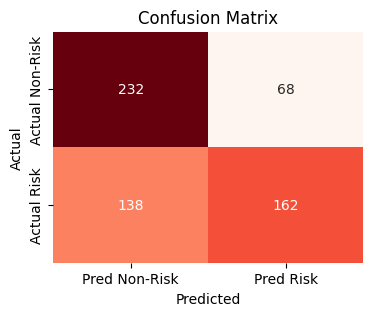



*** Portuguese ***

600 put aside headlines
Accuracy: 0.657

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.86      0.72       300
           1       0.77      0.45      0.57       300

    accuracy                           0.66       600
   macro avg       0.69      0.66      0.64       600
weighted avg       0.69      0.66      0.64       600




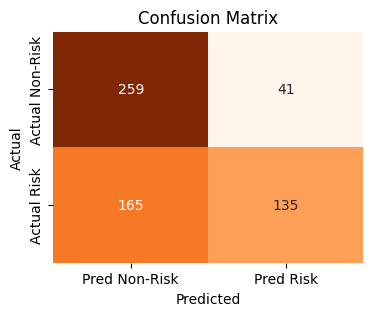

In [12]:
# trains and evaluates a model on the unfiltered data
unfiltered_spanish_classification_report_ = fit_evaluate(spanish_train_df, spanish_put_aside_df, language='Spanish', colors='Reds')
unfiltered_portuguese_classification_report_ = fit_evaluate(portuguese_train_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

### Evaluate improved labels

Evaluates the results of using the improved labels.


*** Spanish ***

600 put aside headlines
Accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.31      0.45       300
           1       0.57      0.93      0.71       300

    accuracy                           0.62       600
   macro avg       0.69      0.62      0.58       600
weighted avg       0.69      0.62      0.58       600




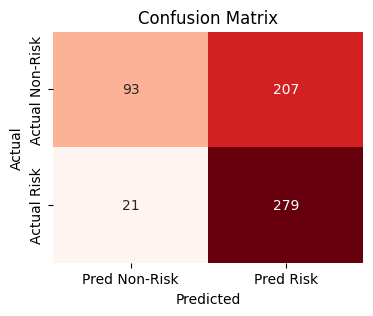



*** Portuguese ***

600 put aside headlines
Accuracy: 0.69

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.48      0.61       300
           1       0.63      0.90      0.74       300

    accuracy                           0.69       600
   macro avg       0.73      0.69      0.68       600
weighted avg       0.73      0.69      0.68       600




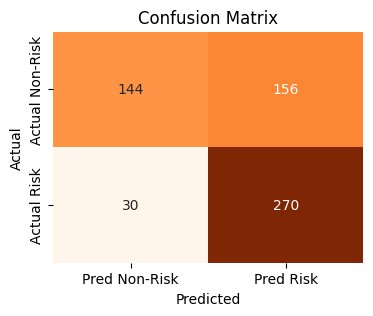

In [13]:
# trains and evaluates a model on the filtered data
filtered_spanish_classification_report_ = fit_evaluate(false_positives_filtered_spanish_df, spanish_put_aside_df, language='Spanish', colors='Reds')
filtered_portuguese_classification_report_ = fit_evaluate(false_positives_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

## Repeat...

Given that the process above improved the model, it stands to reason that repeating the false negative filtering process with predictions based on the newly refined dataset could improve the model even further. The results below show that although the overall accuracy for both models declined (likely because we are dropping badly needed data), the most important metric for this project (risk headlines recall) went up. 

### Generate new predictions

In [14]:
# resets the indices
false_positives_filtered_spanish_df.reset_index(drop=True, inplace=True)
false_positives_filtered_portuguese_df.reset_index(drop=True, inplace=True)

# creates additional dataframes with new predictions based on a model trained on the newly filtered dataframe
spanish_df_3, spanish_df_4 = return_headline_preds(false_positives_filtered_spanish_df, 'Spanish')
portuguese_df_3, portuguese_df_4 = return_headline_preds(false_positives_filtered_portuguese_df, 'Portuguese')

### Find new false negatives threshold

In [15]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
new_spanish_percent = view_nonrisk_highest_rows(spanish_df_4, 7001, 7011)
new_portuguese_percent = view_nonrisk_highest_rows(portuguese_df_4, 1681, 1691)


Total non-risk headlines: 7999

9348:   centros comerciales implementan ia través wifi impulsar ventas
10864:   alperovich condenado 16 años prisión
10113:   recorte presupuesto general reflejará educación salud
5296:   ‘me mató mató ego’ armie hammer habla
11376:   realizan reunión seguridad regionalse llevó cabo mesa trabajo presidentes municipales mandos únicos región iii tepehuanes finalidad analizar aspectos generales materia de…
5183:   disputado 11 18 jornadas liga independiente beisbol
10357:   liberaron tres ex jugadores vélez permanecían detenidos abuso sexual tucumán
5507:   cielo gonzález debía ser condenada magistrado jorge caldas
6627:   escribe chapodiputada libro historia capo
9465:   embajada unidos adelantará citas trámite visa conozca cómo saber si seleccionado

Total non-risk headlines: 2006

2680:   veja quantos casos registrados bairro rio
2784:   ibaneis assina ordem serviço construção feira santa maria
2430:   desmatamento amazônia cai menor nível desde 2015
18

### Drop headlines and evaluate new results


*** Spanish ***

600 put aside headlines
Accuracy: 0.605

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.25      0.39       300
           1       0.56      0.96      0.71       300

    accuracy                           0.60       600
   macro avg       0.71      0.60      0.55       600
weighted avg       0.71      0.60      0.55       600




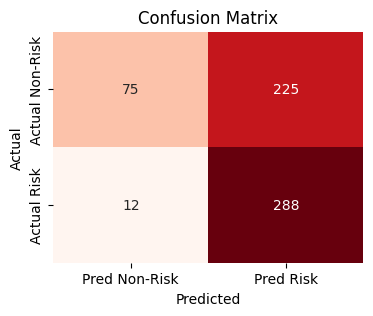



*** Portuguese ***

600 put aside headlines
Accuracy: 0.662

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.39      0.54       300
           1       0.61      0.93      0.73       300

    accuracy                           0.66       600
   macro avg       0.73      0.66      0.64       600
weighted avg       0.73      0.66      0.64       600




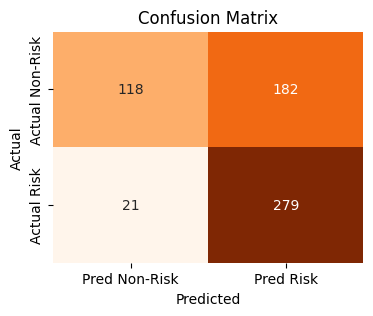

In [16]:
# create new filtered dfs with fewer non-risk headlines
new_filtered_spanish_df = create_filtered_df(spanish_df_3, spanish_df_4, new_spanish_percent)
new_filtered_portuguese_df = create_filtered_df(portuguese_df_3, portuguese_df_4, new_portuguese_percent)

# evaluates the results
filtered_spanish_classification_report_ = fit_evaluate(new_filtered_spanish_df, spanish_put_aside_df, language='Spanish', colors='Reds')
filtered_portuguese_classification_report_ = fit_evaluate(new_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese', colors='Oranges')

## Visualize results

The results show a significant improvement for risk headline recall for both langugaes.

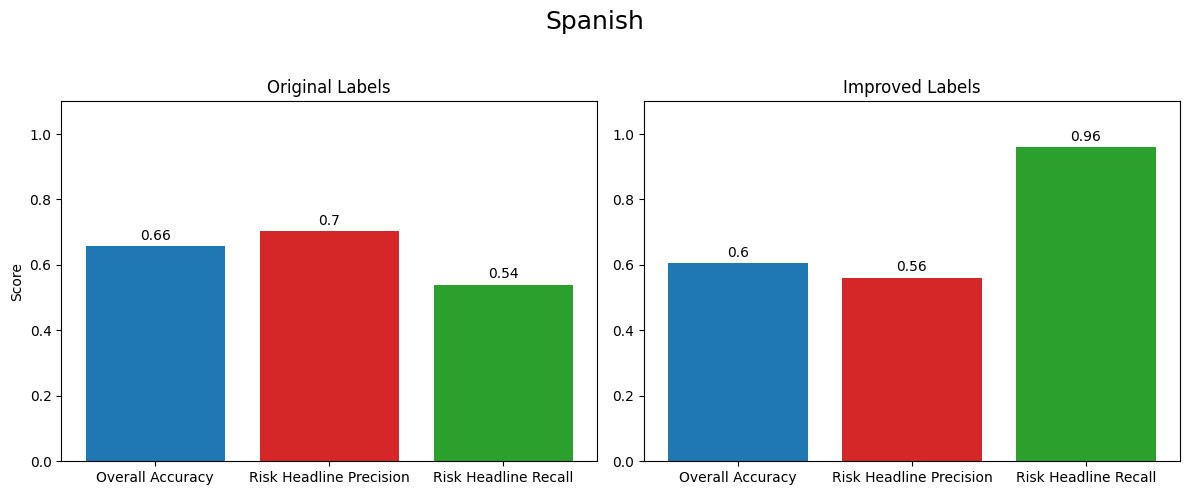

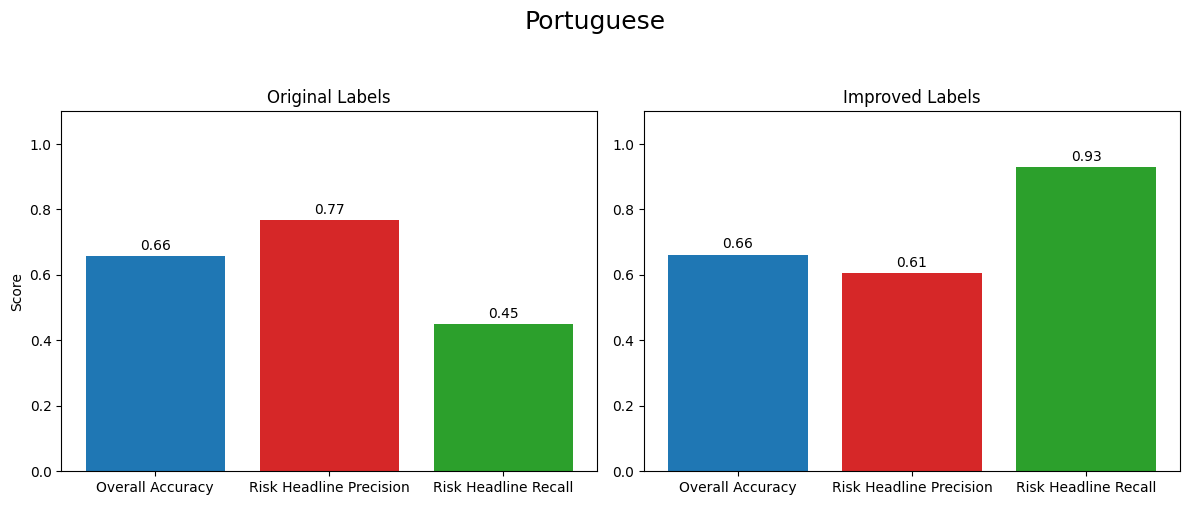

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# data
base_model_spanish = [
    unfiltered_spanish_classification_report_['accuracy'],
    unfiltered_spanish_classification_report_['1']['precision'],
    unfiltered_spanish_classification_report_['1']['recall']
]
new_model_spanish = [
    filtered_spanish_classification_report_['accuracy'],
    filtered_spanish_classification_report_['1']['precision'],
    filtered_spanish_classification_report_['1']['recall']
]
base_model_portuguese = [
    unfiltered_portuguese_classification_report_['accuracy'],
    unfiltered_portuguese_classification_report_['1']['precision'],
    unfiltered_portuguese_classification_report_['1']['recall']
]
new_model_portuguese = [
    filtered_portuguese_classification_report_['accuracy'],
    filtered_portuguese_classification_report_['1']['precision'],
    filtered_portuguese_classification_report_['1']['recall']
]

# labels for the statistics
labels = ['Overall Accuracy', 'Risk Headline Precision', 'Risk Headline Recall']
colors = ['tab:blue', 'tab:red', 'tab:green']

# create subplots for Spanish
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot baseline model stats for Spanish
bars = axs[0].bar(labels, base_model_spanish, color=colors)
axs[0].set_title('Original Labels')
axs[0].set_ylim(0, 1.1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot new model stats for Spanish
bars = axs[1].bar(labels, new_model_spanish, color=colors)
axs[1].set_title('Improved Labels')
axs[1].set_ylim(0, 1.1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title for Spanish
fig.suptitle('Spanish', fontsize=18)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_spanish_metrics.png', dpi=600, bbox_inches='tight')

# show the Spanish plot
plt.show()

# create subplots for Portuguese
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot baseline model stats for Portuguese
bars = axs[0].bar(labels, base_model_portuguese, color=colors)
axs[0].set_title('Original Labels')
axs[0].set_ylim(0, 1.1)
axs[0].set_ylabel('Score')

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# plot new model stats for Portuguese
bars = axs[1].bar(labels, new_model_portuguese, color=colors)
axs[1].set_title('Improved Labels')
axs[1].set_ylim(0, 1.1)

# add numeric labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# add overall title for Portuguese
fig.suptitle('Portuguese', fontsize=18, y=1)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_portuguese_metrics.png', dpi=600, bbox_inches='tight')

# show the Portuguese plot
plt.show()

## Save dataframes

Finally, the refined dataframes are saved as CSV files for further use in additional notebooks.

In [18]:
# filtered dataframes (for use in further training)
new_filtered_spanish_df.to_csv('../Data/spanish_improved_labels_df.csv', index=False)
new_filtered_portuguese_df.to_csv('../Data/portuguese_improved_labels_df.csv', index=False)